In [2]:
import os
from PIL import Image
import pandas as pd
import numpy as np

In [9]:
# Method that takes a filepath to the folder containing the cyrillic images. Loops through each file, returning
# a dataframe with the image data and classification in a pandas dataframe.

# TAs: When grading, you can simply pass in the filepath to the folder containing the validation cyrillic images
# into this method and it should return a dataframe with the image data appropriately resized and manipulated.
# HOWEVER NOTE: This method assumes that the structure of passed-in folder is the same as that of
# the folder of cyrillic training data provided. If the folder structure is not the same, then you'll need to
# write your own for loop and then use the get_image_data method found below.

def build_images_data(cyrillic_path):
    df = pd.DataFrame()

    for dirName, subdirList, fileNames in os.walk(cyrillic_path):
        for i, fileName in enumerate(fileNames):
            if fileName.endswith(".png"):
    #             print "{n}. {dirName}/{fileName}".format(n=i, dirName=dirName, fileName=fileName)
                img_bitmap = get_image_data(os.path.join(dirName, fileName))
                character = dirName.split("/")[-1]
                df = df.append(pd.DataFrame([[character, img_bitmap]], columns=['classification', 'imageData']), ignore_index=True)
        
    return df

In [64]:
# Method for taking a filepath to the cyrillic png and returning transformed data.
# This method returns a flat array of 0s and 1s, according to whether the image was black or white.
binarizer = np.vectorize(lambda i: 1 if i > 0 else 0)

IMAGE_EDGE_SIZE = 50

def get_image_data(filepath):
        img = Image.open(filepath)
        img = img.resize((IMAGE_EDGE_SIZE, IMAGE_EDGE_SIZE), Image.ANTIALIAS)
        bitmap = np.array(img.getdata())
        bitmap = bitmap[:,3] # only need the fourth item in the RGB (transparency)
        bitmap = binarizer(bitmap) # change bitmap to 1 or 0
        img.close()
        return bitmap

In [12]:
# Put a Cyrillic folder in the same folder as this file
cyrillic_path = "../Cyrillic"
        
df = build_images_data(cyrillic_path)

df.head()

,classification,imageData
0,Б,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Б,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Б,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Б,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Б,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [251]:
y_data = pd.Categorical(df["classification"]).codes
x_data = list(df["imageData"].values)

UNIQUE_CLASSES = pd.Categorical(df['classification']).unique()
N_CLASSES = len(UNIQUE_CLASSES)

# Train Neural Net

In [301]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3)

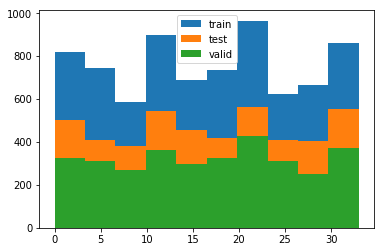

In [302]:
import matplotlib.pyplot as plt

plt.hist(y_train)
plt.hist(y_test)
plt.hist(y_valid)
plt.legend(["train", "test", "valid"])
plt.show()

In [303]:
# Format the y data into an array of 34 items, with 1 for the correct answer

import keras.utils as kutils

y_train = kutils.to_categorical(y_train, num_classes=N_CLASSES, dtype='int8')
y_test  = kutils.to_categorical(y_test,  num_classes=N_CLASSES, dtype='int8')
y_valid = kutils.to_categorical(y_valid, num_classes=N_CLASSES, dtype='int8')

In [382]:
from keras.models import Sequential
from keras.layers import Dense

nn = Sequential()

layers = [
    Dense(units=200, activation='relu', input_dim=IMAGE_EDGE_SIZE**2),
    Dense(units=300, activation='relu'),
    Dense(units=500, activation='relu'),
    Dense(units=300, activation='relu'),
    Dense(units=200, activation='relu'),
    Dense(units=100, activation='relu'),
    Dense(units=50, activation='relu'),
]

for layer in layers:
    nn.add(layer)

OutputLayer = Dense(units=N_CLASSES, activation='softmax')
nn.add(OutputLayer)

nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_138 (Dense)            (None, 200)               500200    
_________________________________________________________________
dense_139 (Dense)            (None, 300)               60300     
_________________________________________________________________
dense_140 (Dense)            (None, 500)               150500    
_________________________________________________________________
dense_141 (Dense)            (None, 300)               150300    
_________________________________________________________________
dense_142 (Dense)            (None, 200)               60200     
_________________________________________________________________
dense_143 (Dense)            (None, 100)               20100     
_________________________________________________________________
dense_144 (Dense)            (None, 50)                5050      
__________

In [383]:
# transform data into format keras likes. This shouldn't be necessary but I'm not sure how to do it beautifully.

def transform(data):
    for i, row in enumerate(data):
        data[i] = np.array(row)
    return data

y_train = transform(y_train)
y_test  = transform(y_test)
y_valid = transform(y_valid)

In [384]:
# Same with x data

x_train = np.array(x_train)
x_test  = np.array(x_test)
x_valid = np.array(x_valid)

In [385]:
nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
output = nn.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_valid, y_valid))

Train on 7585 samples, validate on 3251 samples
Epoch 1/20
7585/7585 [==============================] - 8s 1ms/step - loss: 2.7549 - acc: 0.2127 - val_loss: 2.0458 - val_acc: 0.3839
Epoch 2/20
7585/7585 [==============================] - 6s 820us/step - loss: 1.6881 - acc: 0.4841 - val_loss: 1.6255 - val_acc: 0.5155
Epoch 3/20
7585/7585 [==============================] - 6s 799us/step - loss: 1.1778 - acc: 0.6252 - val_loss: 1.3843 - val_acc: 0.5872
Epoch 4/20
7585/7585 [==============================] - 6s 805us/step - loss: 0.8929 - acc: 0.7134 - val_loss: 1.3544 - val_acc: 0.6026
Epoch 5/20
7585/7585 [==============================] - 5s 624us/step - loss: 0.6724 - acc: 0.7834 - val_loss: 1.3149 - val_acc: 0.6500
Epoch 6/20
7585/7585 [==============================] - 6s 831us/step - loss: 0.5569 - acc: 0.8173 - val_loss: 1.1786 - val_acc: 0.6847
Epoch 7/20
7585/7585 [==============================] - 5s 654us/step - loss: 0.4209 - acc: 0.8596 - val_loss: 1.2836 - val_acc: 0.6832
Ep

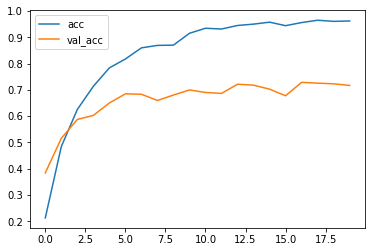

In [386]:
plt.plot(output.history["acc"])
plt.plot(output.history["val_acc"])
plt.legend(["acc", "val_acc"])

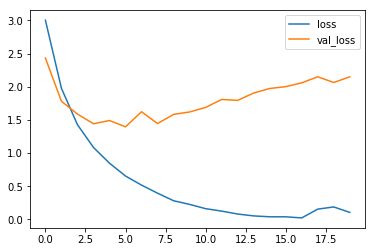

In [387]:
plt.plot(result.history["loss"])
plt.plot(result.history["val_loss"])
plt.legend(["loss", "val_loss"])

In [388]:
results = nn.evaluate(x_test, y_test)
print "Loss: {}".format(results[0])
print "Acc:  {}".format(results[1])

4644/4644 [==============================] - 0s 106us/step
Loss: 1.52552203835
Acc:  0.720284237726
